In [1]:
# Module for data manipulation
import pandas as pd
# Module for linear algebra calculation
import numpy as np
# Module for constructing the data
from sklearn.datasets import make_regression
# Module for factor analysis
from factor_analyzer import FactorAnalyzer
# Module for adequacy test
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity
from factor_analyzer.factor_analyzer import calculate_kmo
# Module for standardization
from sklearn.preprocessing import MinMaxScaler, StandardScaler


## Import Relevant Data

In [6]:
df_global_peace = pd.read_excel(r"../../datasets/general/global_peace_index_2024.xlsx")

df_corrupt = pd.read_excel(r"../../datasets/general/CPI2023_Global_Results__Trends.xlsx", skiprows=3)
df_ookla = pd.read_excel(r"../../datasets/general/ookla_speed_test.xlsx")

df_iata = pd.read_excel(r"../../datasets/research/iata_afr_airlines.xlsx")
df_visa= pd.read_excel(r"../../datasets/research/business_report/visa_open.xlsx")
df_wdi = pd.read_excel(r"../../datasets/world_bank/WDIEXCEL.xlsx")
df_ddt = pd.read_excel(r"../../datasets/ddt/ddt_complete.xlsx")
df_gdp_pc = pd.read_excel(r"../../datasets/dashboards/country_profiles/country_profiles.xlsx", sheet_name=0)

In [36]:
df_num_conf = pd.read_excel(r'../../datasets/general/num_conference_venues.xlsx')

### Clean Data

In [7]:
df_wdi =df_wdi[df_wdi['Indicator Code'] == 'NE.TRD.GNFS.ZS']
df_wdi = df_wdi[df_wdi['Country Code'].isin(df_global_peace['iso3_country_code'])]
df_wdi = df_wdi.reset_index()
df_wdi= df_wdi[['Country Name',	'Country Code',	'Indicator Name', 'Indicator Code', '2021', '2022', '2023']]

#### Fill Null with Regional Mean

In [8]:
df_global_peace['score'] = df_global_peace.groupby('region_name')['score'].transform(lambda x: x.fillna(x.mean()))
df_ookla

,number,Country,Mbps
0,160,Afghanistan,3.63
1,86,Albania,62.71
2,146,Algeria,14.26
3,136,Angola,18.58
4,111,Antigua and Barbuda,40.58
...,...,...,...
156,90,Venezuela,59.81
157,32,Vietnam,151.69
158,158,Yemen,7.54
159,137,Zambia,18.20


In [9]:
df_ookla['Country'] = df_ookla['Country'].str.strip()
df_ookla.rename(columns={'Country':'country_name', 'Mbps':'internet_speed'},inplace=True)
df_ookla = df_ookla[df_ookla['country_name'].isin(df_global_peace['country_name'])]
df_combined = df_global_peace.merge(df_ookla[['country_name', 'internet_speed']], on=['country_name'], how='left')

#### Fill Null with Regional Mean

In [10]:
df_combined['internet_speed'] = df_combined.groupby('region_name')['internet_speed'].transform(lambda x: x.fillna(x.mean()))


#### Fill null with 0s for IATA data

In [11]:
df_iata = df_iata.groupby('Territory').count()
df_iata = df_iata[['Airline Name']]
df_iata = df_iata.reset_index()
df_iata = df_iata.rename(columns={'Territory': 'country_name', 'Airline Name': 'num_airlines'})

In [12]:
df_combined = df_combined.merge(df_iata[['country_name', 'num_airlines']], on=['country_name'], how='left')

#### Filter for UNWTO Data

In [13]:
# Step 1: Filter and reshape the data
relevant_indicators = ['Total Number of Rooms', 'Total Number of Bed Places',
                       'Total Business and Professional Travelers']
filtered_df = df_ddt[df_ddt['indicator_ddt_name'].isin(relevant_indicators)]

In [14]:
# Sort by country and indicator year in descending order
df_sorted = filtered_df.sort_values(by=['iso3_country_code', 'indicator_year'], ascending=[True, False])

# Drop duplicates to get the latest year per country
df_latest = df_sorted.drop_duplicates(subset=['iso3_country_code', 'indicator_ddt_name'], keep='first')


#### Clean WDI

In [15]:
df_wdi.rename(columns={'Country Code' : 'iso3_country_code', 'Country Name' : 'country_name'}, inplace=True)
df_wdi = df_wdi.merge(df_combined[['region_name', 'iso3_country_code']], on = 'iso3_country_code', how = 'left')

In [16]:
for i, row in df_wdi.iterrows():
    if pd.isna(row['2023']): 
        row['2023_filled'] = row['2022']
        print(row['2022'])

nan
91.42296985227196
145.74346852166622
nan
nan
135.5604376136332
nan
nan
nan
64.95664088520934


In [17]:
df_wdi['2023_filled_trade'] = df_wdi.groupby('region_name')['2023'].transform(lambda x: x.fillna(x.mean()))


In [18]:
df_combined = df_combined.merge(df_wdi[['iso3_country_code', '2023_filled_trade']], on='iso3_country_code', how = 'left')

#### Clean Remaining

In [19]:
df_corrupt.rename(columns={'ISO3' : 'iso3_country_code'}, inplace=True)

In [20]:
df_combined = df_combined.merge(df_corrupt[['iso3_country_code', 'CPI score 2023']], on='iso3_country_code', how = 'left')

In [21]:
df_gdp_pc = df_gdp_pc.query(""" Metric == 'GDP per capita (current US$)' """)
df_gdp_pc.rename(columns={'Country' : 'iso3_country_code', 'Latest Value' : 'gdp_pc_2022'}, inplace=True)


In [22]:
df_combined = df_combined.merge(df_gdp_pc[['iso3_country_code', 'gdp_pc_2022']], on='iso3_country_code', how = 'left')

In [23]:
df_latest = df_latest[['iso3_country_code', 'indicator_year'	,'indicator_value', 'indicator_ddt_name',	'country_name'	,'region_name'	]]

In [24]:
df_latest = df_latest.pivot_table(index=['iso3_country_code','country_name','indicator_year', 'region_name'],
                                     columns='indicator_ddt_name', 
                                     values='indicator_value').reset_index()

In [25]:
df_latest = df_latest.drop_duplicates(subset= ['iso3_country_code',	'country_name'	])

In [26]:
df_combined = df_combined.merge(df_latest[['iso3_country_code', 'Total Business and Professional Travelers',	'Total Number of Bed Places',	'Total Number of Rooms', 'indicator_year']], on='iso3_country_code', how = 'left')

In [27]:
df_combined = df_combined[df_combined['iso3_country_code'].isin(df_ddt['iso3_country_code'].unique().tolist())]

In [28]:
df_combined['num_airlines'] = df_combined['num_airlines'].fillna(value=0)

In [29]:
df_combined['peace_inverted'] = 1 / df_combined['score']


In [30]:
df_visa.rename(columns={'Score':'visa_score', 'Country' : 'country_name'}, inplace=True)
df_combined = df_combined.merge(df_visa[['visa_score', 'country_name']], on='country_name', how='left')

#### Fill UNWTO

3 step process for filling using regression, and aggregates from regions or latest data. 

In [31]:
from sklearn.linear_model import LinearRegression

# Step 1: Prepare data for modeling
# Remove rows where both bed places and rooms are NaN (we can't model with missing data)
df_both_not_nan = df_combined.dropna(subset=['Total Number of Bed Places', 'Total Number of Rooms'])

# Step 2: Train linear regression models
# Model 1: Predict Bed Places from Rooms
bed_places_model = LinearRegression()
bed_places_model.fit(df_both_not_nan[['Total Number of Rooms']], df_both_not_nan['Total Number of Bed Places'])

# Model 2: Predict Rooms from Bed Places
rooms_model = LinearRegression()
rooms_model.fit(df_both_not_nan[['Total Number of Bed Places']], df_both_not_nan['Total Number of Rooms'])

# Model 3: Predict Business and Professional Travelers from Bed Places and Rooms
travelers_model = LinearRegression()
df_clean_travelers = df_both_not_nan.dropna(subset=['Total Business and Professional Travelers'])
travelers_model.fit(df_clean_travelers[['Total Number of Bed Places', 'Total Number of Rooms']],
                    df_clean_travelers['Total Business and Professional Travelers'])

# Step 3: Impute missing values based on the models

# Function to fill missing values
def fill_missing_values(row):
    if pd.isna(row['Total Number of Bed Places']) and not pd.isna(row['Total Number of Rooms']):
        # Fill bed places using rooms
        row['Total Number of Bed Places'] = bed_places_model.predict([[row['Total Number of Rooms']]])[0]
    elif pd.isna(row['Total Number of Rooms']) and not pd.isna(row['Total Number of Bed Places']):
        # Fill rooms using bed places
        row['Total Number of Rooms'] = rooms_model.predict([[row['Total Number of Bed Places']]])[0]
    
    if pd.isna(row['Total Business and Professional Travelers']):
        if not pd.isna(row['Total Number of Bed Places']) and not pd.isna(row['Total Number of Rooms']):
            # Fill business travelers using bed places and rooms
            row['Total Business and Professional Travelers'] = travelers_model.predict(
                [[row['Total Number of Bed Places'], row['Total Number of Rooms']]])[0]
    
    return row

# Step 4: Apply the function to each row
df_filled = df_combined.apply(fill_missing_values, axis=1)

# Step 5: For rows where both 'Total Number of Bed Places' and 'Total Number of Rooms' are NaN, fill using regional average
df_filled['Total Number of Bed Places'] = df_filled.groupby('region_name')['Total Number of Bed Places'].apply(lambda x: x.fillna(x.mean()))
df_filled['Total Number of Rooms'] = df_filled.groupby('region_name')['Total Number of Rooms'].apply(lambda x: x.fillna(x.mean()))
df_filled['Total Business and Professional Travelers'] = df_filled.groupby('region_name')['Total Business and Professional Travelers'].apply(lambda x: x.fillna(x.mean()))


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not

In [32]:
df_filled = df_filled.dropna(subset=['gdp_pc_2022'])
df_filled.drop(columns=['ranking', 'indicator_year', 'score'], inplace=True)


In [33]:
df_filled = df_filled.reset_index()
index_dict = dict(zip(df_filled.index, df_filled.iso3_country_code))

In [38]:
df_filled = df_filled.merge(df_num_conf, on=['country_name'], how ='left')

In [40]:
df_filled['num_conf_venues'] = df_filled['num_conf_venues'].fillna(value=0)

In [41]:
df_filled= df_filled.dropna()
df_num = df_filled.drop(columns = ['country_name', 'region_name', 'iso3_country_code', 'index'])
#df_num = df_num.dropna()

In [42]:
scaler = StandardScaler()
df_scaled = pd.DataFrame(data = scaler.fit_transform(df_num),
                         columns = df_num.columns)
df_scaled.head()

,internet_speed,num_airlines,2023_filled_trade,CPI score 2023,gdp_pc_2022,Total Business and Professional Travelers,Total Number of Bed Places,Total Number of Rooms,peace_inverted,visa_score,num_conf_venues
0,-0.779841,0.951469,-0.635167,0.217623,0.606390,0.238270,0.429165,0.515403,-0.282450,-1.207726,-0.323381
1,-0.453617,0.190294,-0.208062,-0.026616,0.118886,-0.647871,-0.499510,-0.283013,0.883078,-0.961076,-0.323381
2,-0.159109,-0.570881,-0.526920,0.787513,-0.497703,-0.287543,0.097786,-0.178901,0.050750,1.670945,-0.323381
3,-1.212541,0.190294,-0.190433,2.090118,1.839951,-0.322755,-0.329323,-0.424786,1.568618,-0.532683,-0.323381
4,1.601896,-0.570881,-0.244152,0.624687,-0.669436,0.075258,-0.131007,-0.230794,-1.374681,0.006054,-0.323381


# Clustering Algorithm

In [35]:
df_filled.isna().sum()

index                                        0
iso3_country_code                            0
country_name                                 0
region_name                                  0
internet_speed                               0
num_airlines                                 0
2023_filled_trade                            0
CPI score 2023                               0
gdp_pc_2022                                  0
Total Business and Professional Travelers    0
Total Number of Bed Places                   0
Total Number of Rooms                        0
peace_inverted                               0
visa_score                                   2
dtype: int64

In [54]:
from sklearn.cluster import KMeans

# Normalize the data - important for K-Means
scaler = StandardScaler()
cluster_df = df_filled.copy().dropna()
# cluster_df.loc[cluster_df['iso3_country_code'] == 'TCD', 'Total Expenditure on Inbound Tourism'] /= 1000000
# cluster_df.loc[cluster_df['iso3_country_code'] == 'TCD', 'Total Expenditure on Outbound Tourism'] /= 1000000

df_normalized = scaler.fit_transform(cluster_df.drop(columns=['country_name', 'region_name', 'iso3_country_code', 'index'], axis=1))

# Perform K-Means Clustering
kmeans = KMeans(n_clusters=4, random_state=42)
cluster_df['Cluster'] = kmeans.fit_predict(df_normalized)

# # Mapping cluster numbers to descriptive categories
# cluster_mapping = {
#     2: 'Nascent Tourism Market',# can be undeveloped
#     0: 'Emerging Tourism Industry', #Can be developing 
#     #2: 'Industry with Potential',
#     1: 'Established Tourism Industry',
#     3: 'Advancing Tourism Economy' # can be Emerging rousim leader
# }
# cluster_df['Tourism Category'] = cluster_df['Cluster'].map(cluster_mapping)

# # Creating a final DataFrame with country and tourism category
# final_df = cluster_df[['iso3_country_code', 'Tourism Category']]

# # Display the final DataFrame
# final_df.head()


In [57]:
cluster_df.groupby('Cluster').count()

,index,iso3_country_code,country_name,region_name,internet_speed,num_airlines,2023_filled_trade,CPI score 2023,gdp_pc_2022,Total Business and Professional Travelers,Total Number of Bed Places,Total Number of Rooms,peace_inverted,visa_score
Cluster,,,,,,,,,,,,,,
0,19,19,19,19,19,19,19,19,19,19,19,19,19,19
1,27,27,27,27,27,27,27,27,27,27,27,27,27,27
2,3,3,3,3,3,3,3,3,3,3,3,3,3,3
3,3,3,3,3,3,3,3,3,3,3,3,3,3,3


# Factor Analysis

In [43]:
chiSquareValue, pValue = calculate_bartlett_sphericity(df_scaled)
print('Chi-square value : {}'.format(round(chiSquareValue, ndigits = 3)))
print('p-value          : {}'.format(round(pValue, ndigits = 3)))

Chi-square value : 201.296
p-value          : 0.0


In [44]:
# Adequacy test - Kaiser-Meyer-Olkin test
KMO, KMO_model = calculate_kmo(df_scaled)
print('KMO value : {}'.format(round(KMO_model, ndigits = 3)))

KMO value : 0.586


In [45]:
# Create factor analysis object and perform factor analysis
fa = FactorAnalyzer(n_factors = 6, rotation = 'varimax')
fa.fit(df_scaled)
# The communalities
df_communalities = pd.DataFrame(data = {'Column': df_scaled.columns, 'Communality': fa.get_communalities()})
#df_communalities.style.apply(highlightC#ommunalities, subset = ['Communality'])

In [46]:
print(df_communalities.to_markdown())

|    | Column                                    |   Communality |
|---:|:------------------------------------------|--------------:|
|  0 | internet_speed                            |      0.30894  |
|  1 | num_airlines                              |      1.00294  |
|  2 | 2023_filled_trade                         |      0.296856 |
|  3 | CPI score 2023                            |      0.511421 |
|  4 | gdp_pc_2022                               |      1.00312  |
|  5 | Total Business and Professional Travelers |      0.481027 |
|  6 | Total Number of Bed Places                |      0.848939 |
|  7 | Total Number of Rooms                     |      0.996752 |
|  8 | peace_inverted                            |      0.612767 |
|  9 | visa_score                                |      0.750317 |
| 10 | num_conf_venues                           |      0.29066  |


In [47]:
# Check Eigenvalues
eigenValue, value = fa.get_eigenvalues()

In [48]:
df_eigen = pd.DataFrame({'Factor': range(1, len(eigenValue) + 1), 'Eigen value': eigenValue})

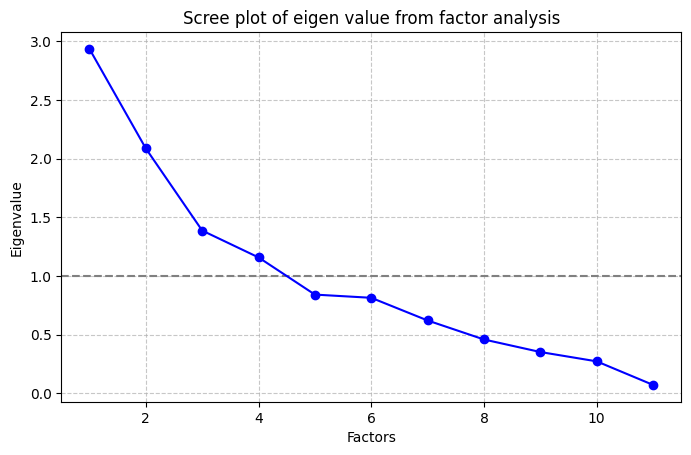

In [49]:
import matplotlib.pyplot as plt

# Matplotlib equivalent of the plot
plt.figure(figsize=(8, 4.8))
plt.axhline(y=1, color='gray', linestyle='--')  # Horizontal line at y=1

# Plot line and points
plt.plot(df_eigen['Factor'], df_eigen['Eigen value'], marker='o', linestyle='-', color='blue')

# Labels and title
plt.title('Scree plot of eigen value from factor analysis')
plt.xlabel('Factors')
plt.ylabel('Eigenvalue')

# Minimal theme
plt.grid(True, linestyle='--', alpha=0.7)  # Minimal style with light grid

# Show plot
plt.show()

In [50]:
facs = ['Factors' + ' ' + str(i + 1) for i in range(6)]
print(facs)
# Loading factors
df_factors = pd.DataFrame(data = fa.loadings_, index = df_scaled.columns, columns = facs)

['Factors 1', 'Factors 2', 'Factors 3', 'Factors 4', 'Factors 5', 'Factors 6']


In [51]:
df_factors

,Factors 1,Factors 2,Factors 3,Factors 4,Factors 5,Factors 6
internet_speed,-0.091238,0.010543,0.498305,-0.110816,0.150530,0.131367
num_airlines,0.409637,0.075595,0.892986,0.104275,-0.089982,0.114162
2023_filled_trade,-0.049512,0.425141,-0.163362,0.152466,0.084271,-0.237958
CPI score 2023,0.052558,0.368673,0.086928,0.340817,0.442566,0.230566
gdp_pc_2022,0.002474,0.934546,0.219260,-0.123082,0.224642,0.126692
Total Business and Professional Travelers,0.641382,-0.056514,0.148906,0.182685,-0.103574,-0.013694
Total Number of Bed Places,0.878877,0.030788,0.027802,-0.143173,0.181529,0.146088
Total Number of Rooms,0.954867,-0.001333,-0.010853,-0.152348,0.109429,0.222884
peace_inverted,0.094405,0.189558,0.070913,0.165156,0.727901,-0.076009
visa_score,-0.066558,0.016632,-0.068405,0.834574,0.205752,0.045640


In [52]:
# Explained variance
idx = ['SS Loadings', 'Proportion Variance', 'Cumulative Variance']
df_variance = pd.DataFrame(data = fa.get_factor_variance(), index = idx, columns = facs)
# Ratio of variance
ratioVariance = fa.get_factor_variance()[1] / fa.get_factor_variance()[1].sum()
df_ratio_var = pd.DataFrame(data = ratioVariance.reshape((1, 6)), index = ['Ratio Variance'], columns = facs)
# New completed dataframe
df_variance.append(df_ratio_var)

/var/folders/nt/03y4p9md50gblp_0svv74zb80000gn/T/ipykernel_59938/950600680.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_variance.append(df_ratio_var)


,Factors 1,Factors 2,Factors 3,Factors 4,Factors 5,Factors 6
SS Loadings,2.338635,1.236329,1.199469,0.984699,0.912202,0.432413
Proportion Variance,0.212603,0.112394,0.109043,0.089518,0.082927,0.039310
Cumulative Variance,0.212603,0.324997,0.434039,0.523557,0.606485,0.645795
Ratio Variance,0.329212,0.174039,0.168850,0.138617,0.128411,0.060871


In [53]:
df_factors = pd.DataFrame(data = fa.fit_transform(df_scaled),
                          index = pd.MultiIndex.from_frame(df_filled[['iso3_country_code', 'country_name', 'region_name', 'index']]),
                          columns = facs)

In [54]:
df_factors

,,,,Factors 1,Factors 2,Factors 3,Factors 4,Factors 5,Factors 6
iso3_country_code,country_name,region_name,index,,,,,,
DZA,Algeria,Northern Africa,0,0.530281,0.418978,0.895238,-0.771704,-0.431798,-0.022862
AGO,Angola,Central Africa,1,-0.300010,-0.220650,0.573801,-0.695774,0.401938,-0.330296
BEN,Benin,Western Africa,2,-0.156753,-0.281830,-0.658261,1.236873,0.432436,0.278428
BWA,Botswana,Southern Africa,3,-0.531661,1.540968,0.507518,-0.263346,1.042051,-0.003740
BFA,Burkina Faso,Western Africa,4,-0.340401,-0.611108,-0.527268,-0.041016,-0.332737,0.455535
BDI,Burundi,Eastern Africa,5,-0.631911,-0.542493,-0.421269,0.691855,-0.413926,-0.008019
CPV,Cabo Verde,Western Africa,6,-0.233892,0.530521,-0.666457,1.160027,0.338653,0.473928
CMR,Cameroon,Central Africa,7,1.154886,-0.432663,-0.222805,-0.800870,-0.953798,0.238431
CAF,Central African Republic,Central Africa,8,-0.478869,-0.764494,-0.327449,-0.879205,-0.837614,0.158821


In [55]:
scaler = MinMaxScaler()
df_factors_scaled = pd.DataFrame(data = scaler.fit_transform(df_factors),
                                 index = pd.MultiIndex.from_frame(df_filled[['iso3_country_code', 'country_name', 'region_name']]),
                                 columns = facs)

In [56]:
print(df_ratio_var.to_markdown())

|                |   Factors 1 |   Factors 2 |   Factors 3 |   Factors 4 |   Factors 5 |   Factors 6 |
|:---------------|------------:|------------:|------------:|------------:|------------:|------------:|
| Ratio Variance |    0.329212 |    0.174039 |     0.16885 |    0.138617 |    0.128411 |   0.0608711 |


In [57]:
# Perform aggregation
dict_index = {}
for i in range(6):
    key = df_factors_scaled.columns[i]
    value = df_factors_scaled.iloc[:,i].values * df_ratio_var.iloc[:,i].values
    dict_index.update({key:value})
# Create a dataframe
df_index = pd.DataFrame(dict_index,
                                 index = pd.MultiIndex.from_frame(df_filled[['iso3_country_code', 'country_name', 'region_name']])

                        )

In [58]:
# Assign the composite index and ranking
df_index.drop(columns=['Factors 5',	'Factors 6'], inplace=True)
df_index['Composite Index'] = df_index.sum(axis = 1).values
df_index['Rank'] = df_index['Composite Index'].rank(ascending = False)
df_index = df_index.sort_values(by = 'Rank').reset_index()

In [59]:
df_index

,iso3_country_code,country_name,region_name,Factors 1,Factors 2,Factors 3,Factors 4,Composite Index,Rank
0,TUN,Tunisia,Northern Africa,0.329212,0.047425,0.021936,0.046965,0.445536,1.0
1,NGA,Nigeria,Western Africa,0.094211,0.038728,0.118373,0.138617,0.389929,2.0
2,EGY,Egypt,Northern Africa,0.148769,0.008628,0.168850,0.033881,0.360128,3.0
3,SYC,Seychelles,Eastern Africa,0.020246,0.174039,0.042920,0.106416,0.343621,4.0
4,ZAF,South Africa,Southern Africa,0.128565,0.065435,0.086450,0.053863,0.334312,5.0
5,GHA,Ghana,Western Africa,0.156050,0.016653,0.031689,0.089335,0.293727,6.0
6,ETH,Ethiopia,Eastern Africa,0.138004,0.019095,0.028613,0.090742,0.276453,7.0
7,MAR,Morocco,Northern Africa,0.151239,0.043920,0.032124,0.042713,0.269995,8.0
8,MUS,Mauritius,Eastern Africa,0.018043,0.113554,0.055270,0.072983,0.259850,9.0
9,UGA,Uganda,Eastern Africa,0.200671,0.013090,0.000000,0.043366,0.257127,10.0


In [60]:
with pd.ExcelWriter(path=r'../../datasets/indicators/bus_indx.xlsx') as writer:
    df_index.to_excel(writer, sheet_name='indexscores')
    df_factors.to_excel(writer, sheet_name='factors')
    df_ratio_var.to_excel(writer, sheet_name='var')


In [83]:
dfindcomb= df_combined.merge(df_index[['iso3_country_code', 'Composite Index']], on='iso3_country_code')

In [86]:
df_combined

,iso3_country_code,country_name,region_name,score,ranking,internet_speed,num_airlines,2023_filled_trade,CPI score 2023,gdp_pc_2022,Total Business and Professional Travelers,Total Number of Bed Places,Total Number of Rooms,indicator_year,peace_inverted
0,DZA,Algeria,Northern Africa,2.433000,NaN,14.260000,2.0,46.195894,36.0,0.314331,NaN,NaN,32837.0,1997.0,0.411015
1,AGO,Angola,Central Africa,2.040000,73.0,18.580000,1.0,66.534149,33.0,0.211017,37.0,18590.0,15728.0,2022.0,0.490196
2,BEN,Benin,Western Africa,2.306000,114.0,22.480000,0.0,51.350465,43.0,0.080347,153.6,42245.0,17959.0,2020.0,0.433651
3,BWA,Botswana,Southern Africa,1.863000,50.0,8.530000,1.0,67.373636,59.0,0.575753,NaN,25330.0,12690.0,2018.0,0.536769
4,BFA,Burkina Faso,Western Africa,2.969000,149.0,45.800000,0.0,64.815596,41.0,0.043953,271.0,33184.0,16847.0,2022.0,0.336814
5,BDI,Burundi,Eastern Africa,2.570000,126.0,21.385000,0.0,29.593248,20.0,0.000000,47.0,NaN,7292.0,2017.0,0.389105
6,CPV,Cabo Verde,Western Africa,2.364933,NaN,10.700000,0.0,93.865171,64.0,0.269045,NaN,28851.0,15257.0,2022.0,0.422845
7,CMR,Cameroon,Central Africa,2.773000,137.0,9.940000,1.0,38.600000,27.0,0.100410,NaN,48838.0,46067.0,2021.0,0.360620
8,CAF,Central African Republic,Central Africa,3.009000,150.0,26.470000,0.0,43.480570,24.0,0.012934,1.2,NaN,NaN,2020.0,0.332336
9,TCD,Chad,Central Africa,2.704000,135.0,26.470000,0.0,91.577081,20.0,0.035237,17.4,4005.0,2011.0,2021.0,0.369822
